# モジュールのインポート

In [9]:
import re
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import openpyxl
from openpyxl.drawing.line import LineProperties
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font

# 必要情報を入力

In [4]:
# 各フォルダの読み込み
folder_list = glob.glob(r'.\input\spectra_data\*')

# データの区切りを指定（タブ：'\t', コンマ：',', セミコロン：';'）
sep = '[,;\t]'

# excelファイルの保存先のパス
output_path = r'.\output\\'

# データの読み込み

In [5]:
file_dic = {}
for n, folder in enumerate(folder_list):
    file_dic[f'data_{n+1}'] = glob.glob(folder + '\*')

df_list = []

for folder in file_dic:
    # フォルダ内にファイルがある場合
    if len(file_dic[folder]) > 0:
        # 各種データ保存用のディクショナリを作成
        data_dic = {}

        # テクストファイルの読み込み
        for file in file_dic[folder]:
            # ファイル名の切り取り
            file_name = re.split('[\\\\.]', file)[5]

            # 一時保存用リストの作成
            temp_list = []

            # スペクトルデータの読み込み
            with open(file, encoding='utf-8') as f:
                for row in f:
                    row = row.strip()
                    temp_list.append(re.split(sep, row))
            temp_list = temp_list[32:1069]

            # ディクショナリへデータの格納
            data_dic[file_name] = temp_list

        # 空のデータフレームを作成
        df = pd.DataFrame()

        # フォルダ内データをデータフレームに追加
        for key in data_dic:
            intensity_list = []
            wave_list = []

            for n in range(len(data_dic[key])):
                intensity_list.append(data_dic[key][n][3])

            for n in range(len(data_dic[key])):
                wave_list.append(data_dic[key][n][0])

            df['Raman Shift'] = wave_list
            df[key] = intensity_list

        df = df.astype(float)
        df = df.sort_values(by=['Raman Shift'], ascending=True).reset_index(drop=True)

        df_list.append(df)

    else:
        break

# グラフの可視化

In [22]:
# X軸の最大・最小の設定
XLIM_MIN = 200
XLIM_MAX = 1700
# Y軸の最大・最小の設定
YLIM_MIN = -1000
YLIM_MAX = 20000
# 軸ラベルの設定
XLABEL = 'Raman Shift [cm^-1]'
YLABEL = 'Intensity [a.u.]'
# グラフサイズ
GRAPH_SIZE = (8, 6)
# フォントサイズ
FONTS_SIZE = 14

In [23]:
def show_raman_spectra(spectra_df_list):
    """
    ラマンスペクトルを表示する関数
    :param spectra_df_list: 各スペクトルデータフレームのリスト
    """
    for df in spectra_df_list:
        yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]
        plt.figure(figsize=(25, 4))
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.plot(df['Raman Shift'] , df[yaxis_list[i*10]])
            plt.title(yaxis_list[i*10])
            plt.xlim(XLIM_MIN, XLIM_MAX)
            plt.ylim(YLIM_MIN, YLIM_MAX)

        # plt.xlabel(XLABEL)
        # plt.ylabel(YLABEL)
        # plt.xticks(fontsize=FONTS_SIZE)
        # plt.yticks(fontsize=FONTS_SIZE)
        plt.tight_layout()
        plt.show()

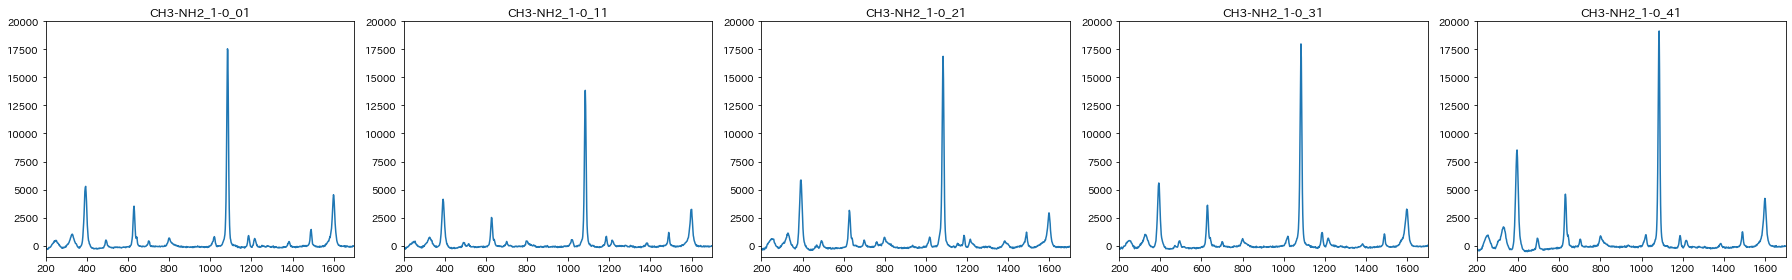

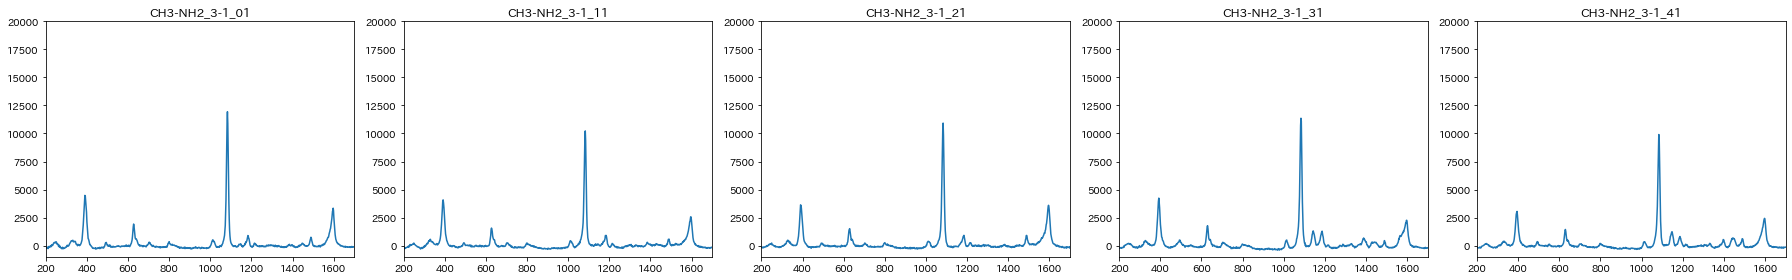

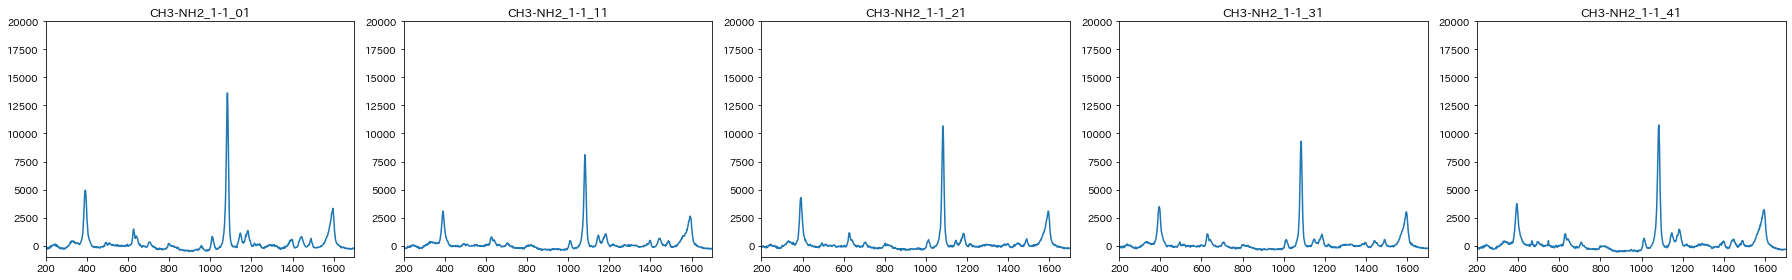

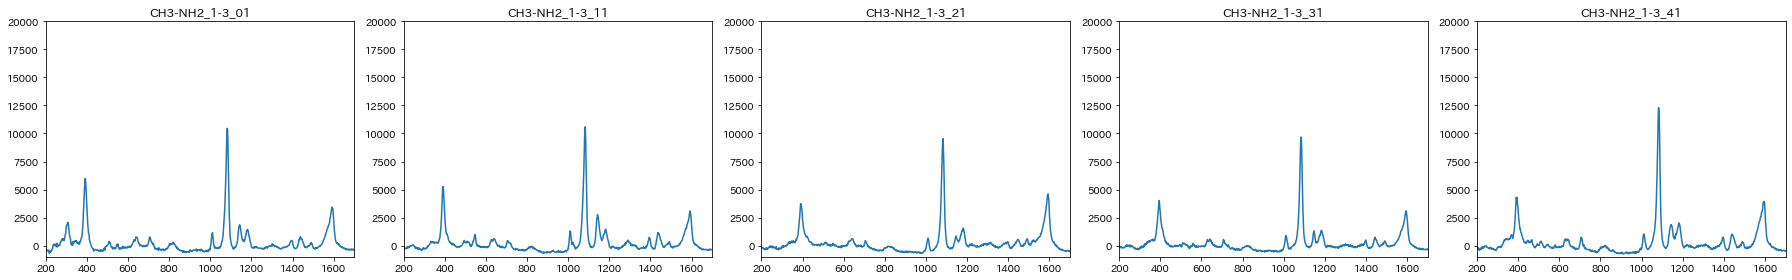

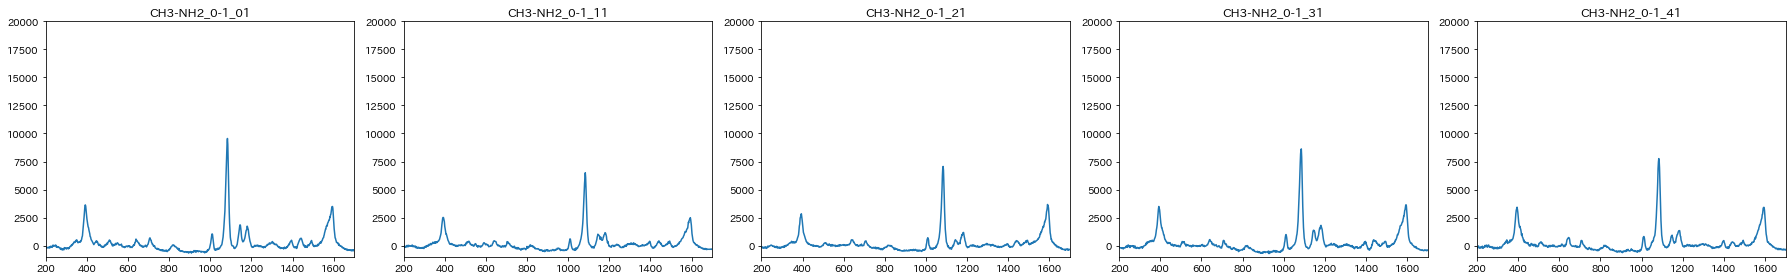

In [24]:
show_raman_spectra(df_list)

# スペクトルデータの正規化

In [25]:
scaled_df_list = []

# 最大強度を1にスケール化
for df in df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]

    scaler = MinMaxScaler()
    series = scaler.fit_transform(df[yaxis_list])
    scaled_df = pd.DataFrame(series)
    scaled_df.columns = yaxis_list
    scaled_df.insert(0, 'Raman Shift', df['Raman Shift'])

    scaled_df_list.append(scaled_df)

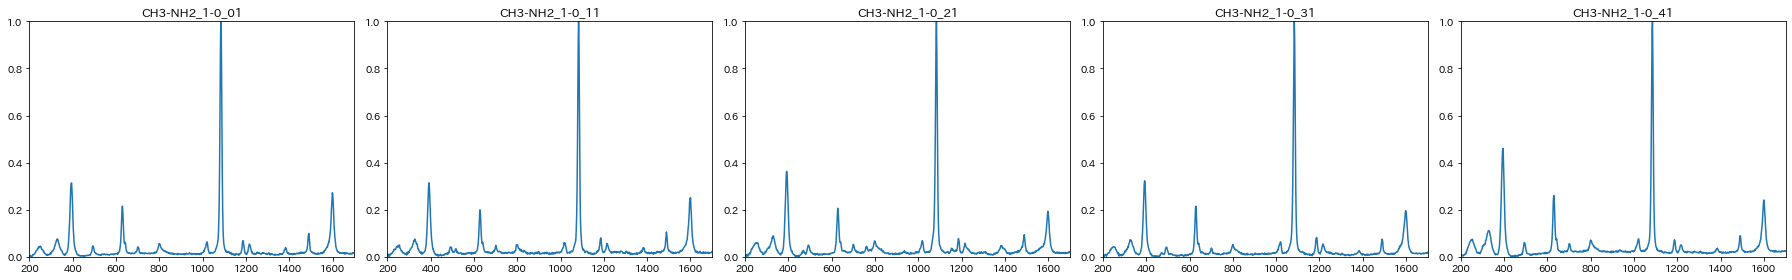

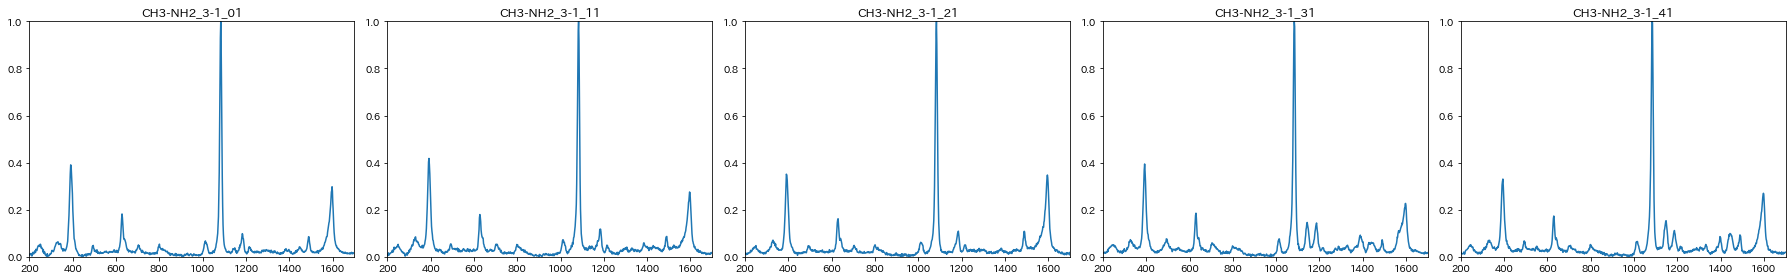

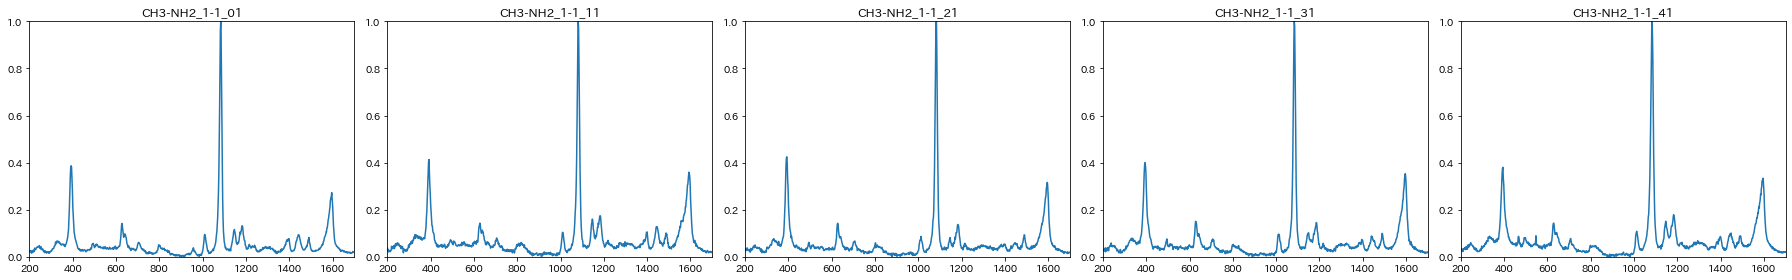

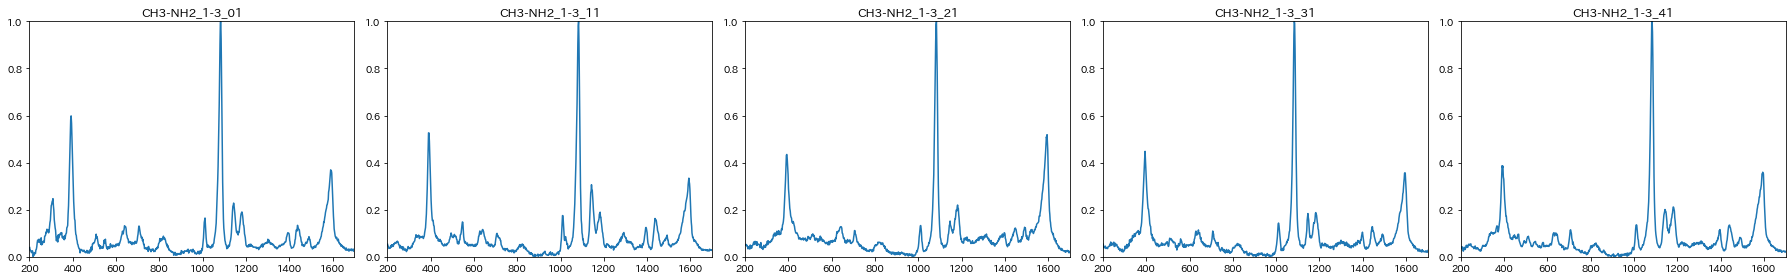

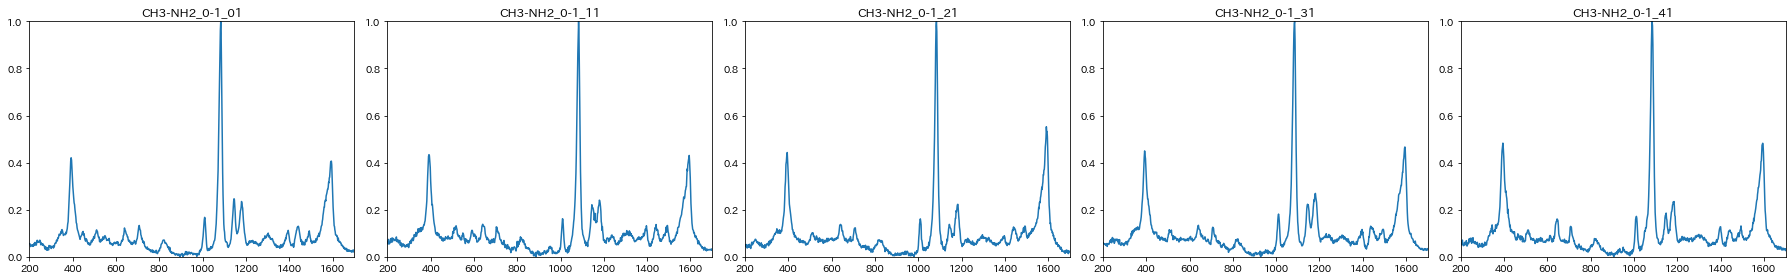

In [26]:
# Y軸の最大・最小の設定
YLIM_MIN = 0
YLIM_MAX = 1

show_raman_spectra(scaled_df_list)

In [27]:
# 解析用にデータフレームの形状を変更
RAMAN_SHIFT = df_list[0]['Raman Shift']

# label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']
# label_list = ['CH3:OH=1:0', 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1']
label_list = ['CH3:NH2=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']
# label_list = ['CH3:COOH=0:1', 'CH3:COOH=1:3', 'CH3:COOH=1:1', 'CH3:COOH=3:1', 'CH3:COOH=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']

for n, df in enumerate(scaled_df_list):
    df.loc[-1] = int(n)

data_df = pd.concat(scaled_df_list, axis=1)
data_df = data_df.drop(['Raman Shift'], axis=1)
data_df = data_df.T
# labelのみ別で保存
data_label = data_df[-1]
# label無しのデータフレーム
data_df = data_df.drop(-1, axis=1)
data_df.columns = RAMAN_SHIFT

# スペクトルデータの標準化（変数方向）

In [28]:
standerd_df_list = []

# スペクトルを波数方向に標準化
for df in df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]

    scaler = StandardScaler()
    series = scaler.fit_transform(df[yaxis_list])
    standerd_df = pd.DataFrame(series)
    standerd_df.columns = yaxis_list
    standerd_df.insert(0, 'Raman Shift', df['Raman Shift'])

    standerd_df_list.append(standerd_df)

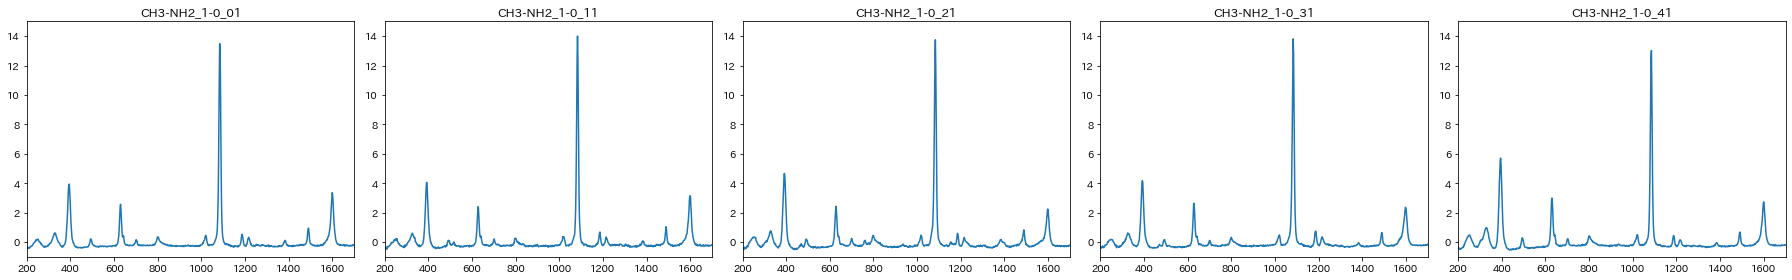

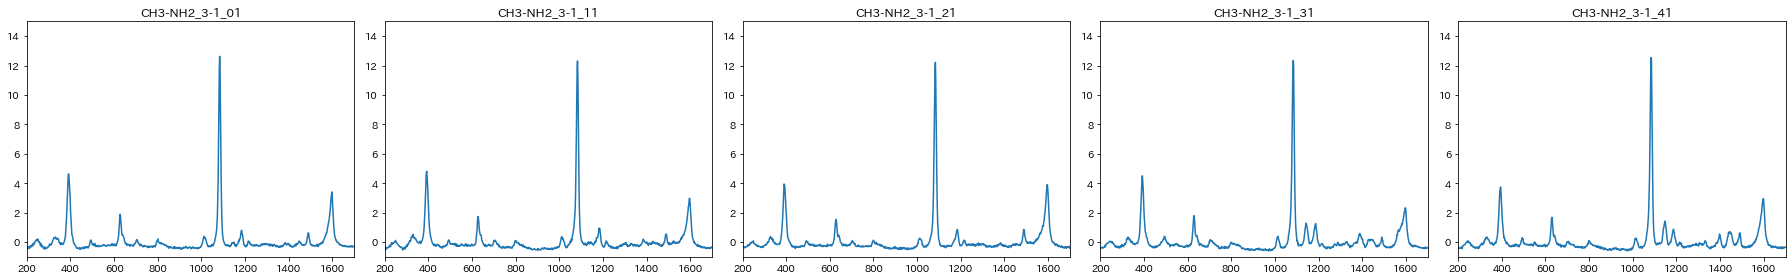

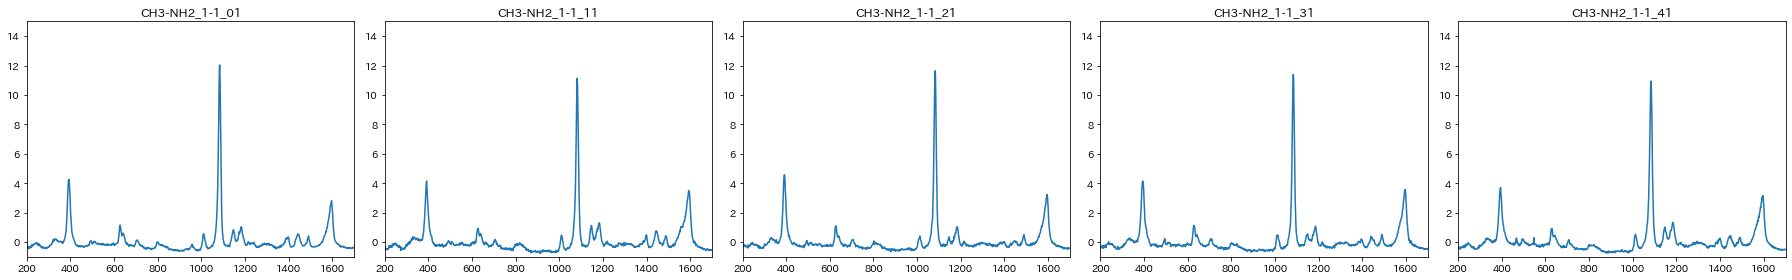

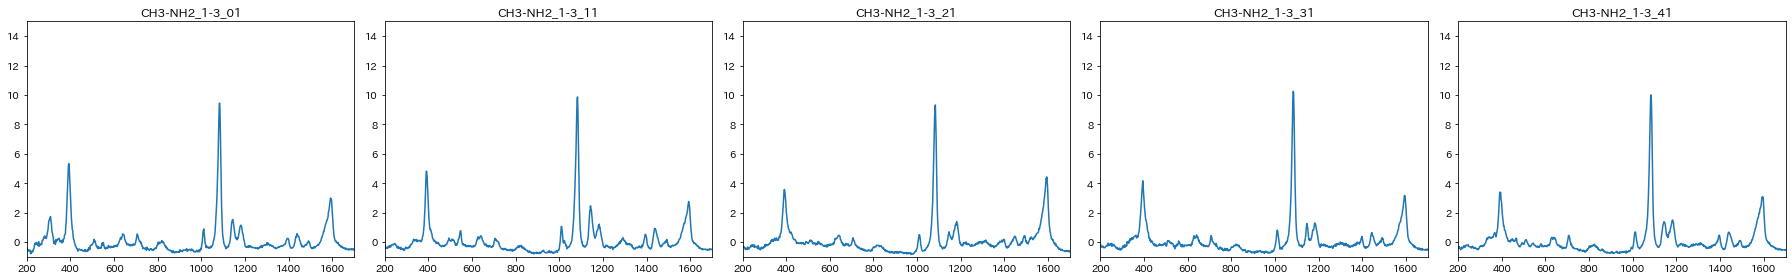

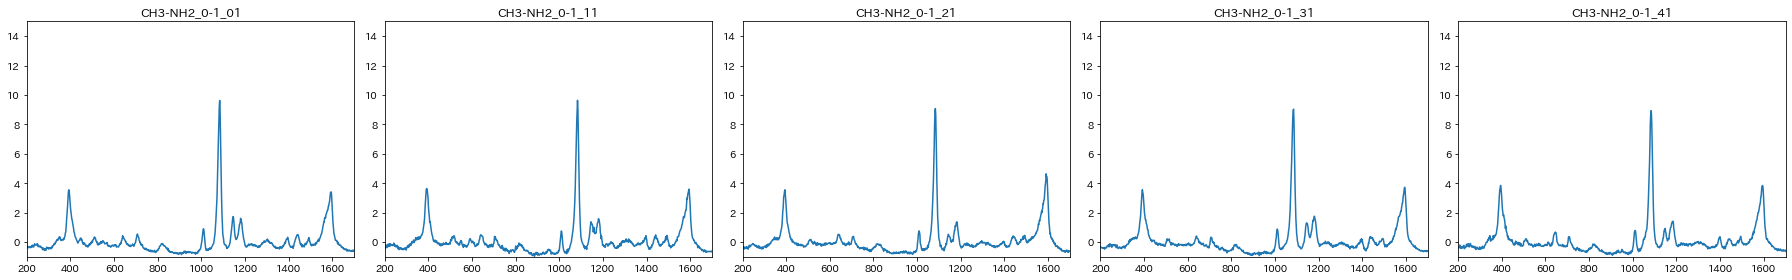

In [29]:
# Y軸の最大・最小の設定
YLIM_MIN = -1
YLIM_MAX = 15

show_raman_spectra(standerd_df_list)

In [30]:
# 解析用に形状変更
for n, df in enumerate(standerd_df_list):
    df.loc[-1] = int(n)

std_data_df = pd.concat(standerd_df_list, axis=1)
std_data_df = std_data_df.drop(['Raman Shift'], axis=1)
std_data_df = std_data_df.T
# labelのみ別で保存
std_data_label = std_data_df[-1]
# label無しのデータフレーム
std_data_df = std_data_df.drop(-1, axis=1)
std_data_df.columns = RAMAN_SHIFT

# データフレームの保存

In [31]:
df_title = 'CH3_NH2_scaled_df'
save_df = data_df.copy()
save_df['label'] = data_label
save_df.to_pickle(output_path + df_title + '.pkl')

df_title = 'CH3_NH2_stander_df'
save_df = std_data_df.copy()
save_df['label'] = std_data_label
save_df.to_pickle(output_path + df_title + '.pkl')

# データフレームの読み込み（保存済みの場合）

In [127]:
label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']
# label_list = ['CH3:OH=1:0', 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1']
# label_list = ['CH3:NH2=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']
# label_list = ['CH3:COOH=0:1', 'CH3:COOH=1:3', 'CH3:COOH=1:1', 'CH3:COOH=3:1', 'CH3:COOH=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']

## 正規化データ

In [131]:
# データフレームの読み込み
dataframe_path = r'.\input\dataframe\\'
# excelファイルの保存先のパス
output_path = r'.\output\\'

dataframe_title = 'CH3_COOH_scaled_df'

data_df = pd.read_pickle(dataframe_path + dataframe_title + '.pkl')
data_df.head()

Raman Shift,201.192791188876,203.237476388369,205.281479548654,207.324801000766,209.367441075527,211.409400103543,213.450678415207,215.491276340697,217.53119420998,219.570432352812,...,1994.36035611163,1995.84667029798,1997.33255467823,1998.81800943131,2000.30303473604,2001.78763077115,2003.27179771526,2004.7555357469,2006.2388450445,label
CH3-COOH_1-0_01,0.009167,0.015687,0.009611,0.008422,0.002401,0.006682,0.009849,0.014186,0.013298,0.015276,...,0.022375,0.021647,0.020201,0.020255,0.023505,0.021797,0.023807,0.022947,0.021759,0.0
CH3-COOH_1-0_02,0.014455,0.011535,0.009954,0.011833,0.012432,0.007859,0.015521,0.021124,0.014055,0.027501,...,0.032174,0.032943,0.031873,0.033845,0.034684,0.034886,0.035371,0.033591,0.034924,0.0
CH3-COOH_1-0_03,0.003706,0.003276,0.002901,0.001596,0.001950,0.007356,0.007082,0.014574,0.010710,0.014859,...,0.025391,0.027310,0.027440,0.026706,0.027451,0.025421,0.025981,0.025985,0.026236,0.0
CH3-COOH_1-0_04,0.012741,0.004619,0.007832,0.004834,0.004279,0.010822,0.007751,0.010226,0.009832,0.013910,...,0.021855,0.023413,0.023656,0.022050,0.022651,0.022595,0.022241,0.024333,0.024754,0.0
CH3-COOH_1-0_05,0.020207,0.015031,0.016544,0.023040,0.012281,0.013707,0.022644,0.019758,0.020718,0.023377,...,0.036726,0.036650,0.036573,0.036054,0.036355,0.038046,0.034999,0.035362,0.035726,0.0


In [132]:
# 特徴量とラベルの分離
data_label = data_df['label']
data_df = data_df.drop('label', axis=1)

In [130]:
# 特徴量選択
data_df = data_df[[394.419068879562, 521.822789854923, 629.442607105158, 1078.23810517042, 1592.78509599397]]

## 標準化データ

In [133]:
dataframe_title = 'CH3_COOH_standerd_df'

data_df = pd.read_pickle(dataframe_path + dataframe_title + '.pkl')
data_df.head()

Raman Shift,201.192791188876,203.237476388369,205.281479548654,207.324801000766,209.367441075527,211.409400103543,213.450678415207,215.491276340697,217.53119420998,219.570432352812,...,1994.36035611163,1995.84667029798,1997.33255467823,1998.81800943131,2000.30303473604,2001.78763077115,2003.27179771526,2004.7555357469,2006.2388450445,label
CH3-COOH_1-0_01,-0.326508,-0.233275,-0.320165,-0.337161,-0.423265,-0.362043,-0.316753,-0.254743,-0.267436,-0.239153,...,-0.137639,-0.148050,-0.168728,-0.167955,-0.121474,-0.145899,-0.117154,-0.129461,-0.146438,0.0
CH3-COOH_1-0_02,-0.394410,-0.431360,-0.451376,-0.427593,-0.420012,-0.477891,-0.380916,-0.309994,-0.399463,-0.229293,...,-0.170151,-0.160409,-0.173957,-0.149000,-0.138377,-0.135819,-0.129683,-0.152211,-0.135337,0.0
CH3-COOH_1-0_03,-0.471493,-0.477443,-0.482622,-0.500686,-0.495787,-0.420981,-0.424780,-0.321115,-0.374581,-0.317167,...,-0.171442,-0.144891,-0.143098,-0.153259,-0.142939,-0.171034,-0.163285,-0.163223,-0.159751,0.0
CH3-COOH_1-0_04,-0.297596,-0.411829,-0.366632,-0.408799,-0.416611,-0.324592,-0.367784,-0.332970,-0.338509,-0.281151,...,-0.169413,-0.147511,-0.144082,-0.166679,-0.158222,-0.159004,-0.163988,-0.134560,-0.128641,0.0
CH3-COOH_1-0_05,-0.361001,-0.428590,-0.408832,-0.324002,-0.464503,-0.445880,-0.329183,-0.366865,-0.354323,-0.319606,...,-0.145290,-0.146285,-0.147286,-0.154068,-0.150129,-0.128045,-0.167842,-0.163094,-0.158350,0.0


In [134]:
# 特徴量とラベルの分離
std_data_label = data_df['label']
std_data_df = data_df.drop('label', axis=1)

In [12]:
std_data_df = std_data_df[[394.419068879562, 521.822789854923, 629.442607105158, 1078.23810517042, 1592.78509599397]]

# 各データの相関確認

<AxesSubplot:xlabel='Raman Shift', ylabel='Raman Shift'>

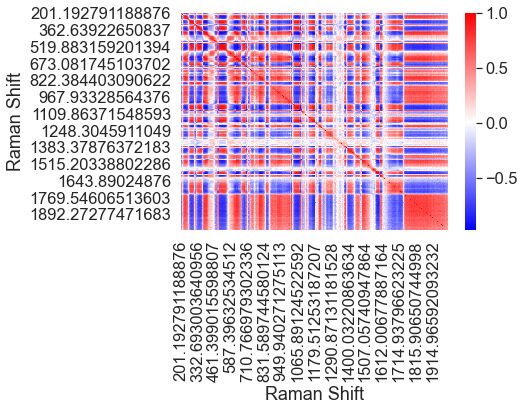

In [135]:
# 正規化データの相関
sns.heatmap(data_df.corr(), cmap="bwr")

<AxesSubplot:xlabel='Raman Shift', ylabel='Raman Shift'>

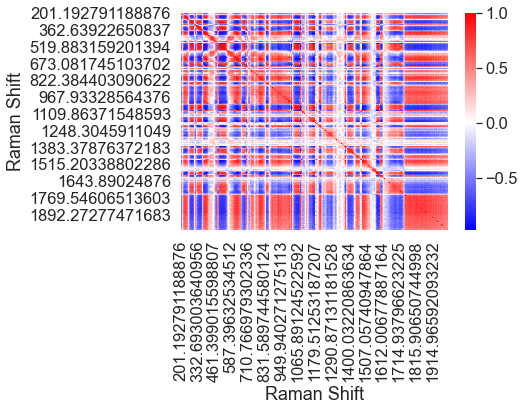

In [136]:
# 標準化データの相関
sns.heatmap(std_data_df.corr(), cmap="bwr")

# Linear SVCによる分類

In [137]:
# kernel:rbf(ガウス関数) その他：linear(線形回帰)、poly(多項式展開)、sigmoidなどがある
def linear_svc(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC(C=C)
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

## 正規化データによる評価

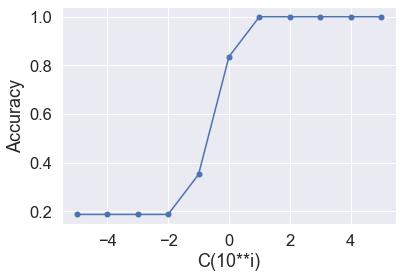

In [138]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = linear_svc(10**i, data_df, data_label)
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [139]:
cm_linear_svc, accuracy_linear_svc = linear_svc(10, data_df, data_label)
print('Accuracy:', accuracy_linear_svc)

Accuracy: 1.0


<AxesSubplot:>

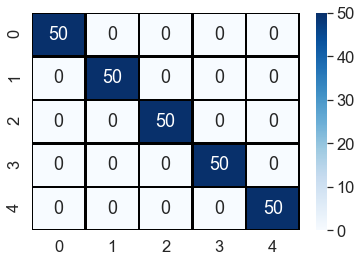

In [140]:
sns.set(font_scale=1.5)
sns.heatmap(cm_linear_svc, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [141]:
def train_linear_svc(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    svm_model = SVC(C=C)
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [142]:
train_cm_linear_svc, train_accuracy_linear_svc = train_linear_svc(10, data_df, data_label)
print('Accuracy:', train_accuracy_linear_svc)

Accuracy: 1.0


<AxesSubplot:>

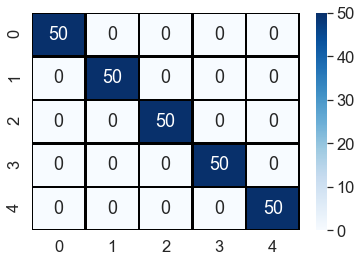

In [143]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_linear_svc, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

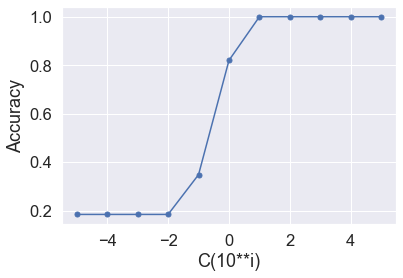

In [144]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = linear_svc(10**i, std_data_df, std_data_label)
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [145]:
std_cm_linear_svc, std_accuracy_linear_svc = linear_svc(10, std_data_df, std_data_label)
print('Accuracy:', std_accuracy_linear_svc)

Accuracy: 1.0


<AxesSubplot:>

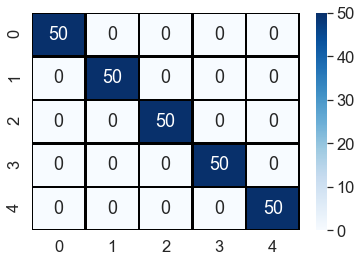

In [146]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_linear_svc, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# PCAによるスペクトルの2次元化

In [31]:
def pca_2d_plot(df, df_label):
    pca = PCA(n_components=2)

    pca_X = pca.fit_transform(df.values)
    pca_result_df = pd.DataFrame(pca_X)
    pca_result_df.columns = ['PC1', 'PC2']
    pca_result_df['label'] = df_label.values

    color_list =['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'glod', 'grey', 'black']

    for i in range(np.unique(data_label).size):
        data = pca_result_df[pca_result_df['label'] == i]
        plt.scatter(data['PC1'], data['PC2'], c=color_list[i], label=label_list[i])

    # 寄与率の算出
    exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_], columns=['PC1', 'PC2'])
    print(exp_var_ratio)

    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=['PC1', 'PC2'])

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(loc='best')
    plt.show()

    return pca_result_df, pca_vec_df

## 正規化データ

       PC1       PC2
0  0.91649  0.069437


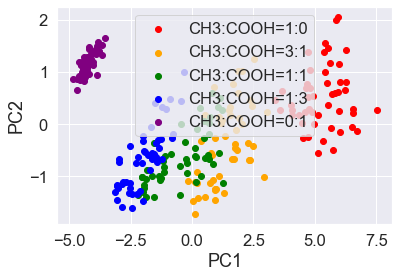

In [34]:
scaled_pca_result_df, scaled_pca_vec_df = pca_2d_plot(data_df, data_label)

<AxesSubplot:>

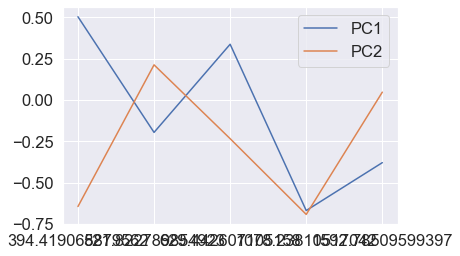

In [35]:
# 固有ベクトルの可視化
scaled_pca_vec_df.T.plot()

## 標準化データ

       PC1       PC2
0  0.91649  0.069437


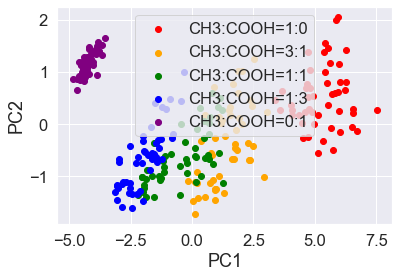

In [36]:
standerd_pca_result_df, standerd_pca_vec_df = pca_2d_plot(std_data_df, std_data_label)

<AxesSubplot:>

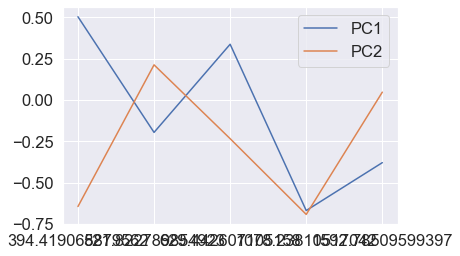

In [37]:
# 固有ベクトルの可視化
standerd_pca_vec_df.T.plot()

# PCA_SVM

In [38]:
def pca_svm(n_comp, C, data_df, label):
    # PCA処理
    pca = PCA(n_components=n_comp)
    X = pca.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'PC{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # 寄与率の算出
    df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_],columns=[f'PC{n+1}' for n in range(n_comp)])
    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=[f'PC{n+1}' for n in range(n_comp)])

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC(C=C)
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return df_exp_var_ratio, pca_vec_df, cm, Accuracy

## クロスバリデーションによる評価

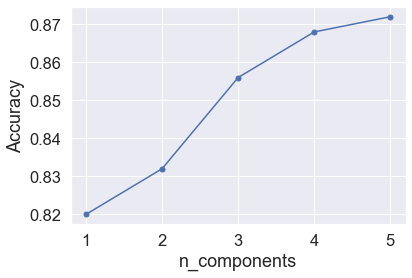

In [42]:
# n_componentsの決定
temp_accuracy_dict = {}

# 全波数での予測時：1-11
for n_comp in range(1, 6, 1):
    _, _, _, accuracy = pca_svm(n_comp, 1, data_df, data_label)
    temp_accuracy_dict[n_comp] = accuracy

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_components')
plt.ylabel('Accuracy')
plt.show()

In [47]:
# n_components = 2
raitio, _, cm, accuracy = pca_svm(5, 10000, data_df, data_label)
print(raitio)
print(accuracy)

       PC1       PC2       PC3       PC4      PC5
0  0.91649  0.069437  0.008151  0.004632  0.00129
0.992


<AxesSubplot:>

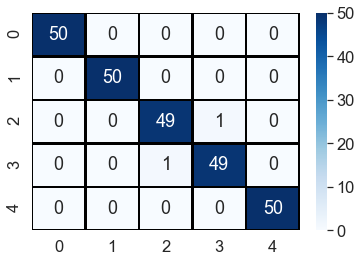

In [48]:
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [49]:
# train_accuracy計算用
def train_pca_svm(n_comp, C, data_df, label):
    # PCA処理
    pca = PCA(n_components=n_comp)
    X = pca.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'PC{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # 寄与率の算出
    df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_],columns=[f'PC{n+1}' for n in range(n_comp)])
    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=[f'PC{n+1}' for n in range(n_comp)])

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']

    svm_model = SVC(C=C)
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)


    return df_exp_var_ratio, pca_vec_df, cm, Accuracy

In [50]:
# train_accuracy
train_raitio, _, train_cm, train_accuracy = train_pca_svm(5, 10000, data_df, data_label)
print(train_raitio)
print(train_accuracy)

       PC1       PC2       PC3       PC4      PC5
0  0.91649  0.069437  0.008151  0.004632  0.00129
1.0


<AxesSubplot:>

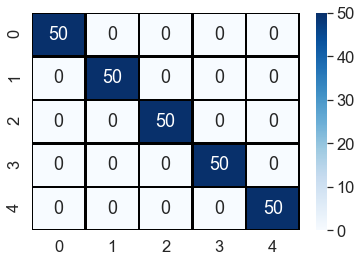

In [51]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

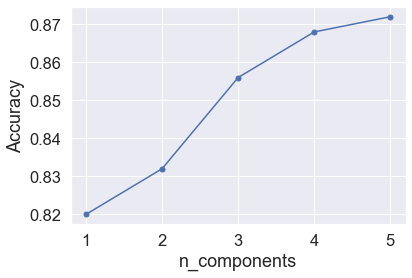

In [52]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 6, 1):
    _, _, _, accuracy = pca_svm(n_comp, 1, std_data_df, std_data_label)
    temp_accuracy_dict[n_comp] = accuracy

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_components')
plt.ylabel('Accuracy')
plt.show()

In [55]:
# 標準化データでの予測
std_raitio, _, std_cm, std_accuracy = pca_svm(5, 10000, std_data_df, data_label)
print(std_raitio)
print(std_accuracy)

       PC1       PC2       PC3       PC4      PC5
0  0.91649  0.069437  0.008151  0.004632  0.00129
0.992


<AxesSubplot:>

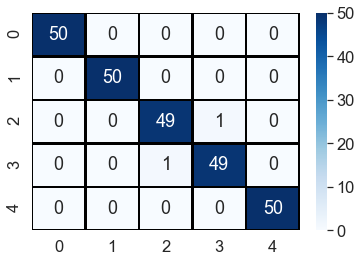

In [56]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# SVM単体での解析

In [57]:
# kernel:rbf(ガウス関数) その他：linear(線形回帰)、poly(多項式展開)、sigmoidなどがある
def svm_only(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC(C=C)
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

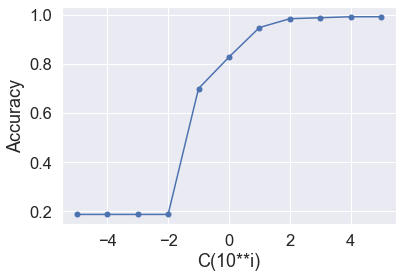

In [58]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = svm_only(10**i, data_df, data_label)
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [59]:
cm_svm, accuracy_svm = svm_only(10000, data_df, data_label)
print('Accuracy:', accuracy_svm)

Accuracy: 0.992


<AxesSubplot:>

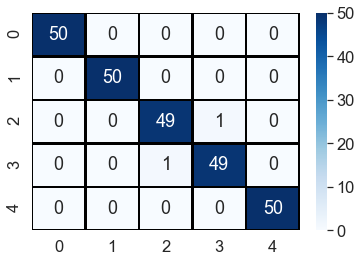

In [60]:
sns.set(font_scale=1.5)
sns.heatmap(cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [61]:
def train_svm_only(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    svm_model = SVC(C=C)
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [62]:
train_cm_svm, train_accuracy_svm = train_svm_only(10000, data_df, data_label)
print('Accuracy:', train_accuracy_svm)

Accuracy: 1.0


<AxesSubplot:>

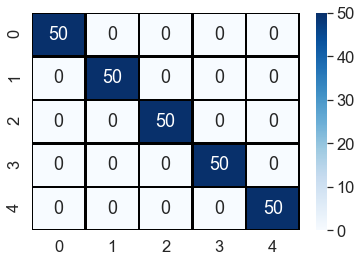

In [63]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

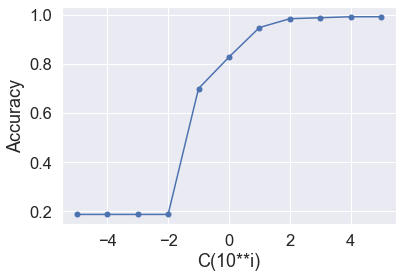

In [64]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = svm_only(10**i, std_data_df, std_data_label)
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [65]:
# 標準化データでの予測
std_cm_svm, std_accuracy_svm = svm_only(10000, std_data_df, data_label)
print('Accuracy:', std_accuracy_svm)

Accuracy: 0.992


<AxesSubplot:>

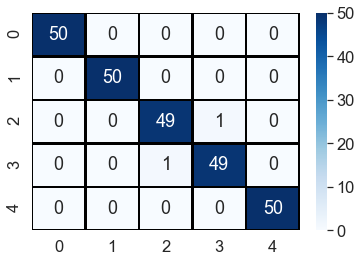

In [66]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# Linear Discriminant Analysis(LDA)

## スペクトルの2次元化

In [67]:
def lda_2D_plot(df, df_label):
    lda = LDA(n_components=2)
    X_r2 = lda.fit(df, df_label).transform(df)

    color_list =['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'glod', 'grey', 'black']

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s' % str(lda.explained_variance_ratio_))

    for i in range(np.unique(data_label).size):
        plt.scatter(X_r2[data_label == i, 0], X_r2[data_label == i, 1],
        c=color_list[i], label=label_list[i])

    # ldaの結果をデータフレーム化
    lda_result_df = pd.DataFrame(X_r2)
    lda_result_df.columns = ['LDA1', 'LDA2']
    lda_result_df['label'] = data_label.values

    plt.xlabel('LDA1')
    plt.ylabel('LDA2')
    plt.legend(loc='best')
    plt.show()

    return lda_result_df

### 正規化データ

explained variance ratio (first two components): [0.95698087 0.04245005]


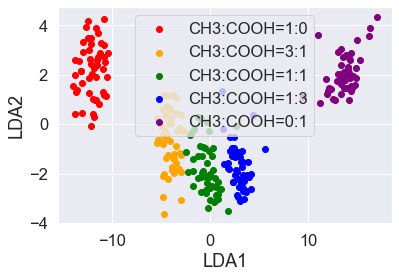

In [68]:
scaled_lda_result_df = lda_2D_plot(data_df, data_label)

### 標準化データ

explained variance ratio (first two components): [0.95698087 0.04245005]


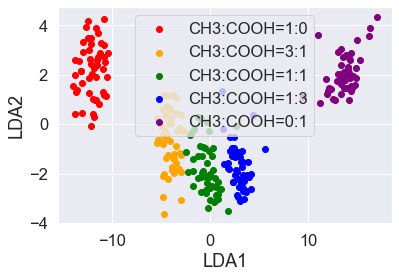

In [69]:
standerd_lda_result_df = lda_2D_plot(std_data_df, std_data_label)

## クロスバリデーションによる評価

In [70]:
def lda_prediction(n_comp, data_df, label):

    X = data_df
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        lda_model = LDA(n_components=n_comp)
        lda_model.fit(train_x, train_y)
        y_pred = lda_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

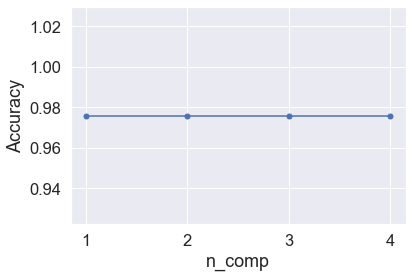

In [71]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 5, 1):
    _, accuracy_lda = lda_prediction(n_comp, data_df, data_label)
    temp_accuracy_dict[n_comp] = accuracy_lda

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_comp')
plt.ylabel('Accuracy')
plt.show()

In [72]:
cm_lda, accuracy_lda = lda_prediction(2, data_df, data_label)
print('Accuracy:', accuracy_lda)

Accuracy: 0.976


<AxesSubplot:>

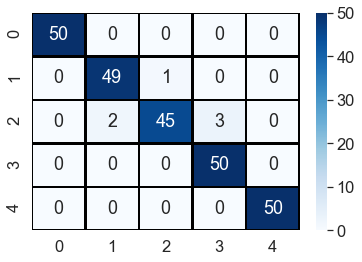

In [73]:
sns.set(font_scale=1.5)
sns.heatmap(cm_lda, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [74]:
def train_lda_prediction(n_comp, data_df, label):

    X = data_df
    y = label

    lda_model = LDA(n_components=n_comp)
    lda_model.fit(X, y)
    y_pred = lda_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [75]:
train_cm_ldan, train_accuracy_ldan = train_lda_prediction(2, data_df, data_label)
print('Accuracy:', train_accuracy_ldan)

Accuracy: 0.984


<AxesSubplot:>

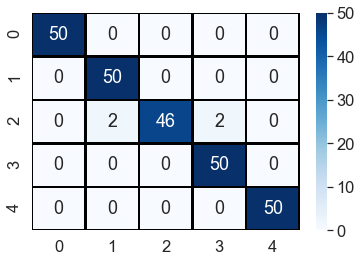

In [76]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_ldan, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

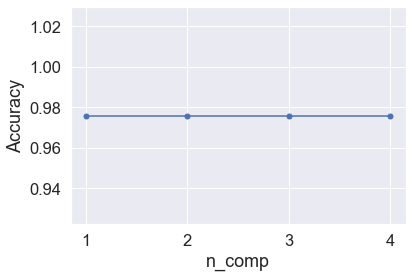

In [77]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 5, 1):
    _, accuracy_lda = lda_prediction(n_comp, std_data_df, std_data_label)
    temp_accuracy_dict[n_comp] = accuracy_lda

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_comp')
plt.ylabel('Accuracy')
plt.show()

In [80]:
# 標準化データでの予測
std_cm_lda, std_accuracy_lda = lda_prediction(2, std_data_df, std_data_label)
print('Accuracy:', std_accuracy_lda)

Accuracy: 0.976


<AxesSubplot:>

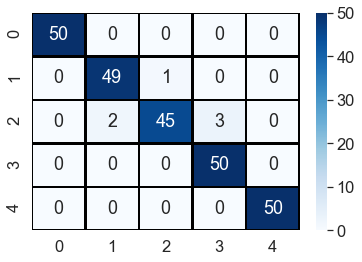

In [81]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_lda, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# t-SNEによるスペクトルの2次元化

In [82]:
def tsne_2D_plot(df, df_label):
    tsne = TSNE(n_components=2, random_state=0, init='pca')

    X = tsne.fit_transform(df.values)
    tsne_result_df = pd.DataFrame(X)
    tsne_result_df.columns = ['tSNE1', 'tSNE2']
    tsne_result_df['label'] = df_label.values

    color_list =['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'glod', 'grey', 'black']

    for i in range(np.unique(df_label).size):
        data = tsne_result_df[tsne_result_df['label'] == i]
        plt.scatter(data['tSNE1'], data['tSNE2'], c=color_list[i], label=label_list[i])

    plt.xlabel('tSNE1')
    plt.ylabel('tSNE2')
    plt.legend(loc='best')
    plt.show()

    return tsne_result_df

## 正規化データ

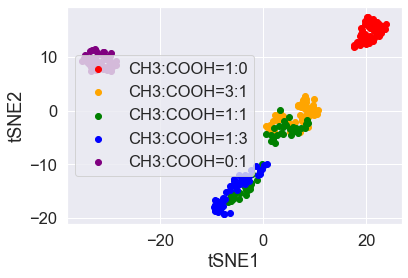

In [83]:
scaled_tsne_result_df = tsne_2D_plot(data_df, data_label)

## 標準化データ

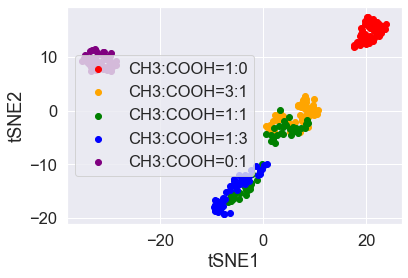

In [84]:
standerd_tsne_result_df = tsne_2D_plot(std_data_df, std_data_label)

# t-SNE_SVM

In [86]:
def tsne_svm(n_comp, C, data_df, label):
    # t-SNE処理
    tsne = TSNE(n_components=n_comp, random_state=0, init='pca')
    X = tsne.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'TSNE{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC(C=C)
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

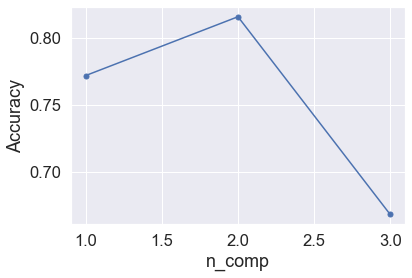

In [87]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 4, 1):
    _, accuracy_tsne_svm = tsne_svm(n_comp, 1, data_df, data_label)
    temp_accuracy_dict[n_comp] = accuracy_tsne_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_comp')
plt.ylabel('Accuracy')
plt.show()

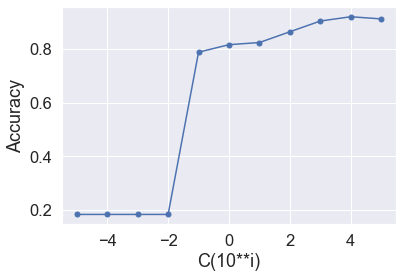

In [88]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_tsne_svm = tsne_svm(2, 10**i, data_df, data_label)
    temp_accuracy_dict[i] = accuracy_tsne_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [89]:
# componet=2
cm_tsne_svm, accuracy_tsne_svm = tsne_svm(2, 10000, data_df, data_label)
print('Accuracy:', accuracy_tsne_svm)

Accuracy: 0.92


<AxesSubplot:>

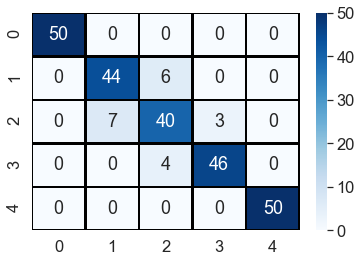

In [90]:
sns.set(font_scale=1.5)
sns.heatmap(cm_tsne_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [91]:
def train_tsne_svm(n_comp, C, data_df, label):
    # t-SNE処理
    tsne = TSNE(n_components=n_comp, random_state=0, init='pca')
    X = tsne.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'TSNE{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']

    svm_model = SVC(C=C)
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [92]:
# componet=2
train_cm_tsne_svm, train_accuracy_tsne_svm = train_tsne_svm(2, 10000, data_df, data_label)
print('Accuracy:', train_accuracy_tsne_svm)

Accuracy: 0.928


<AxesSubplot:>

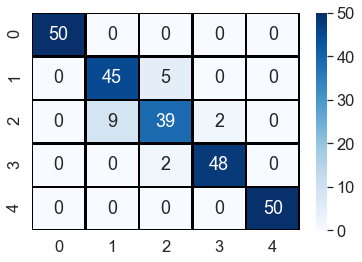

In [93]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_tsne_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

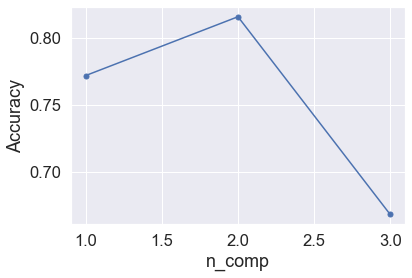

In [94]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 4, 1):
    _, accuracy_tsne_svm = tsne_svm(n_comp, 1, std_data_df, std_data_label)
    temp_accuracy_dict[n_comp] = accuracy_tsne_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_comp')
plt.ylabel('Accuracy')
plt.show()

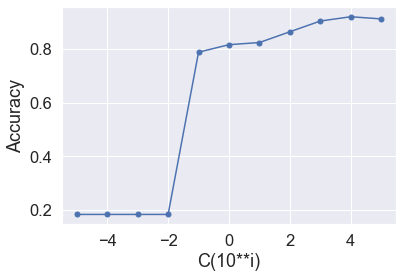

In [95]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_tsne_svm = tsne_svm(2, 10**i, std_data_df, std_data_label)
    temp_accuracy_dict[i] = accuracy_tsne_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [96]:
# 標準化データでの予測
std_cm_tsne_svm, std_accuracy_tsne_svm = tsne_svm(2, 10000, std_data_df, std_data_label)
print('Accuracy:', std_accuracy_tsne_svm)

Accuracy: 0.92


<AxesSubplot:>

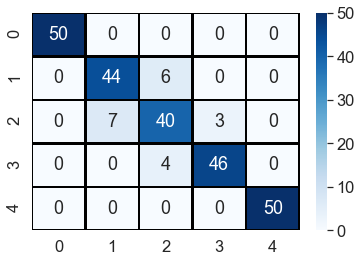

In [97]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_tsne_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# 決定木

## クロスバリデーションによる評価

In [98]:
dt_model = DecisionTreeClassifier(random_state=1234)

# 施行するパラメータを設定
params = {
	'max_depth':[i for i in range(3, 11, 1)],
	'min_samples_split':[i for i in range(2, 11, 1)],
	'min_samples_leaf':[i for i in range(1, 11, 1)]
}

grid_search = GridSearchCV(dt_model, param_grid=params, cv=5)
grid_search.fit(data_df, data_label)

# ベストスコアを表示
print(grid_search.best_score_)
# ベストスコアのパラメータを表示
print(grid_search.best_params_)

0.9399999999999998
{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [99]:
def decision_tree(max_depth, min_leaf, min_split, data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        dt_model = DecisionTreeClassifier(max_depth=max_depth,
                                        min_samples_split=min_split,
                                        min_samples_leaf=min_leaf,
                                        max_leaf_nodes=None,
                                        random_state=1234)

        dt_model.fit(train_x, train_y)
        y_pred = dt_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [100]:
cm_dt, accuracy_dt = decision_tree(7, 1, 2, data_df, data_label)
print('Accuracy:', accuracy_dt)

Accuracy: 0.964


<AxesSubplot:>

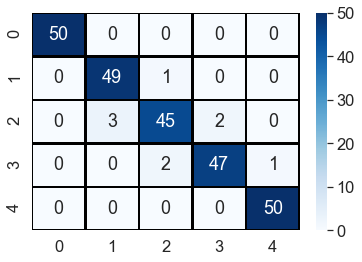

In [101]:
sns.set(font_scale=1.5)
sns.heatmap(cm_dt, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [102]:
def train_decision_tree(max_depth, min_leaf, min_split, data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    dt_model = DecisionTreeClassifier(max_depth=max_depth,
                                        min_samples_split=min_split,
                                        min_samples_leaf=min_leaf,
                                        max_leaf_nodes=None,
                                        random_state=1234)

    dt_model.fit(X, y)
    y_pred = dt_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [103]:
train_cm_dt, train_accuracy_dt = train_decision_tree(7, 1, 2, data_df, data_label)
print('Accuracy:', train_accuracy_dt)

Accuracy: 1.0


<AxesSubplot:>

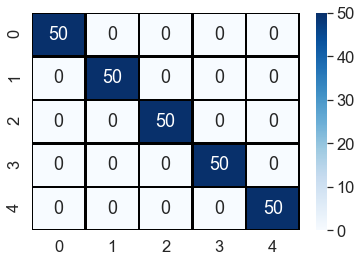

In [104]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_dt, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

In [105]:
dt_model = DecisionTreeClassifier(random_state=1234)

# 施行するパラメータを設定
params = {
	'max_depth':[i for i in range(3, 11, 1)],
	'min_samples_split':[i for i in range(2, 11, 1)],
	'min_samples_leaf':[i for i in range(1, 11, 1)]
}

grid_search = GridSearchCV(dt_model, param_grid=params, cv=5)
grid_search.fit(std_data_df, std_data_label)

# ベストスコアを表示
print(grid_search.best_score_)
# ベストスコアのパラメータを表示
print(grid_search.best_params_)

0.9399999999999998
{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [106]:
std_cm_dt, std_accuracy_dt = decision_tree(7, 1, 2, std_data_df, std_data_label)
print('Accuracy:', std_accuracy_dt)

Accuracy: 0.964


<AxesSubplot:>

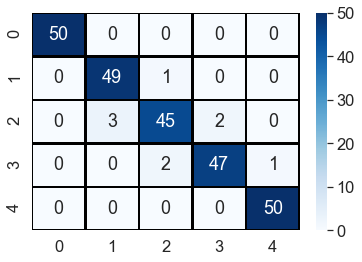

In [107]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_dt, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# MLPによるクラスタリング

In [110]:
MLP_model = MLPClassifier(max_iter=5000, random_state=1234)

# [(100), (200), (300), (50, 50), (50, 100), (100, 50), (100, 100), (200, 100), (200, 200)]
# 施行するパラメータを設定
params = {
	'hidden_layer_sizes':[(20), (30), (50), (20, 20), (30, 20), (30, 30), (50, 20), (50, 30), (50, 50)],
	'activation':['logistic', 'tanh', 'relu'],
	'solver':['sgd', 'adam']
}

X = data_df.copy()
X.columns = [str(i) for i in data_df.columns]

grid_search = GridSearchCV(MLP_model, param_grid=params, cv=5)
grid_search.fit(X, data_label)

# ベストスコアを表示
print(grid_search.best_score_)
# ベストスコアのパラメータを表示
print(grid_search.best_params_)

0.9879999999999999
{'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}


In [111]:
def MLP(hidden_layer, activ, solv, data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        MLP_model = MLPClassifier(hidden_layer_sizes=hidden_layer,
                                activation=activ, # logistic, tanh, relu
                                solver=solv,
                                max_iter=5000,
                                random_state=1234)

        MLP_model.fit(train_x, train_y)
        y_pred = MLP_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [112]:
cm_MLP, accuracy_MLP= MLP((50, 50), 'relu', 'adam', data_df, data_label)
print('Accuracy:', accuracy_MLP)

Accuracy: 0.988


<AxesSubplot:>

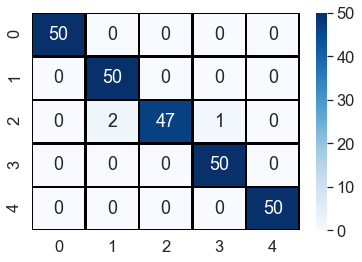

In [113]:
sns.set(font_scale=1.5)
sns.heatmap(cm_MLP, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [114]:
def train_MLP(hidden_layer, activ, solv, data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    MLP_model = MLPClassifier(hidden_layer_sizes=hidden_layer,
                                activation=activ,
                                solver=solv,
                                max_iter=5000,
                                random_state=1234)

    MLP_model.fit(X, y)
    y_pred = MLP_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [115]:
train_cm_MLP, train_accuracy_MLP = MLP((50, 50), 'relu', 'adam', data_df, data_label)
print('Accuracy:', train_accuracy_MLP)

Accuracy: 0.988


<AxesSubplot:>

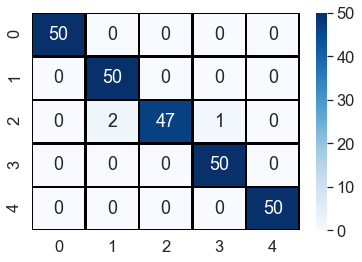

In [116]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_MLP, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

In [117]:
MLP_model = MLPClassifier(max_iter=5000, random_state=1234)

# [(100), (200), (300), (50, 50), (50, 100), (100, 50), (100, 100), (200, 100), (200, 200)]
# 施行するパラメータを設定
params = {
	'hidden_layer_sizes':[(20), (30), (50), (20, 20), (30, 20), (30, 30), (50, 20), (50, 30), (50, 50)],
	'activation':['logistic', 'tanh', 'relu'],
	'solver':['sgd', 'adam']
}

X = std_data_df.copy()
X.columns = [str(i) for i in std_data_df.columns]

grid_search = GridSearchCV(MLP_model, param_grid=params, cv=5)
grid_search.fit(X, std_data_label)

# ベストスコアを表示
print(grid_search.best_score_)
# ベストスコアのパラメータを表示
print(grid_search.best_params_)

0.9879999999999999
{'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}


In [118]:
# 標準化データでの予測
std_cm_MLP, std_accuracy_MLP = MLP((50, 50), 'relu', 'adam', std_data_df, data_label)
print('Accuracy:', std_accuracy_MLP)

Accuracy: 0.988


<AxesSubplot:>

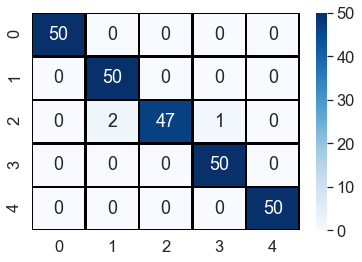

In [119]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_MLP, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# 各データ（スペクトル、PCA、LDA、tSNE）のExcel化

In [132]:
graph_title = 'CH3_NH2_raw_data'

with pd.ExcelWriter(output_path + graph_title + '.xlsx') as writer:
    for n, df in enumerate(df_list):
        df.to_excel(writer, sheet_name=f'data_{n+1}', index=False)

In [123]:
graph_title = 'scaled_pca_result'
scaled_pca_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

graph_title = 'standerd_pca_result'
standerd_pca_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

In [124]:
graph_title = 'scaled_vector'
scaled_pca_vec_df.T.to_excel(output_path + graph_title + '.xlsx', index=False)

graph_title = 'standerd_vector'
standerd_pca_vec_df.T.to_excel(output_path + graph_title + '.xlsx', index=False)

In [125]:
graph_title = 'scaled_lda_result'
scaled_lda_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

graph_title = 'standerd_lda_result'
standerd_lda_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

In [126]:
graph_title = 'scaled_tsne_result'
scaled_tsne_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

graph_title = 'standerd_tsne_result'
standerd_tsne_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)